## TP2 - AdaBosting aplicado ao dataset Tic Tac Toe

    Daniel Barreto Torres
    2018432952

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier, plot_tree

### Carregando o dataset e fazendo algumas transformações

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data"
data = pd.read_csv(url, header=None)
data.columns = ['top-left', 'top-middle', 'top-right', 'middle-left', 'middle-middle', 'middle-right', 'bottom-left', 'bottom-middle', 'bottom-right', 'class']
data

,top-left,top-middle,top-right,middle-left,middle-middle,middle-right,bottom-left,bottom-middle,bottom-right,class
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive
...,...,...,...,...,...,...,...,...,...,...
953,o,x,x,x,o,o,o,x,x,negative
954,o,x,o,x,x,o,x,o,x,negative
955,o,x,o,x,o,x,x,o,x,negative
956,o,x,o,o,x,x,x,o,x,negative


Aqui remodelamos as variáveis categóricas para o padrão one hot encoding que se adapta melhor ao métodos de treinamento do modelo, e definimos os targets para cada amostra como 1 ou 0

In [3]:
X = pd.get_dummies(data.iloc[:, :-1])
y = data.iloc[:, -1].map({'positive': 1, 'negative': 0})
X

,top-left_b,top-left_o,top-left_x,top-middle_b,top-middle_o,top-middle_x,top-right_b,top-right_o,top-right_x,middle-left_b,...,middle-right_x,bottom-left_b,bottom-left_o,bottom-left_x,bottom-middle_b,bottom-middle_o,bottom-middle_x,bottom-right_b,bottom-right_o,bottom-right_x
0,False,False,True,False,False,True,False,False,True,False,...,False,False,False,True,False,True,False,False,True,False
1,False,False,True,False,False,True,False,False,True,False,...,False,False,True,False,False,False,True,False,True,False
2,False,False,True,False,False,True,False,False,True,False,...,False,False,True,False,False,True,False,False,False,True
3,False,False,True,False,False,True,False,False,True,False,...,False,False,True,False,True,False,False,True,False,False
4,False,False,True,False,False,True,False,False,True,False,...,False,True,False,False,False,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953,False,True,False,False,False,True,False,False,True,False,...,False,False,True,False,False,False,True,False,False,True
954,False,True,False,False,False,True,False,True,False,False,...,False,False,False,True,False,True,False,False,False,True
955,False,True,False,False,False,True,False,True,False,False,...,True,False,False,True,False,True,False,False,False,True
956,False,True,False,False,False,True,False,True,False,False,...,True,False,False,True,False,True,False,False,False,True


In [4]:
y

0      1
1      1
2      1
3      1
4      1
      ..
953    0
954    0
955    0
956    0
957    0
Name: class, Length: 958, dtype: int64

### Definindo o modelo

In [63]:
# Classe que modela o algoritmo AdaBosting, combinando stumps (Árvores de decisão de 1 pergunta)
class AdaBosting:

    def __init__(self):
        self.stumps = []
        self.stumps_weight = []

    # Função que treina um stump (uma árvore de decisão com apenas uma pergunta)
    def train_stump(self, X, y, sample_weights):
        stump = DecisionTreeClassifier(max_depth=1)
        stump.fit(X, y, sample_weight=sample_weights)
        
        return stump

    # Processo de treinamento do bosting que agrupa vários stumps
    def boosting(self, X, y, num_interations=50):
        result_stumps = []
        result_stumps_weight = []
        num_samples, num_features = X.shape
        sample_weights = np.ones(num_samples) / num_samples
        
        for _ in range(num_interations):
            stump = self.train_stump(X, y, sample_weights)
            stump_pred = stump.predict(X)
    
            error = np.sum(sample_weights * (stump_pred != y)) / np.sum(sample_weights)
    
            stump_weight = np.log((1 - error) / error) / 2
    
            sample_weights = sample_weights * np.exp(-stump_weight * y * stump_pred)
            sample_weights /= np.sum(sample_weights)
    
            result_stumps.append(stump)
            result_stumps_weight.append(stump_weight)
    
        self.stumps = result_stumps
        self.stumps_weight = result_stumps_weight

        return self

    # Função que prediz para um conjuto de entradas, é necessário ter o modelo treinado antes
    def predict(self, X):
        stumps_preds = np.array([stump_weight * stump.predict(X) for stump, stump_weight in zip(self.stumps, self.stumps_weight)])
        return np.sign(np.sum(stumps_preds, axis=0))

            

### Treinamento e obteção dos resultados

In [64]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

errors = np.zeros((6, 5))
particion = 0

for train_index, test_index in kf.split(X):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    for i, num_iterations in enumerate([1, 2, 5, 25, 50, 100]):
        model = AdaBosting()
        model.boosting(X_train, y_train, num_interations=num_iterations)
        y_pred = model.predict(X_test)

        error = np.mean(y_test != y_pred)

        errors[i][particion] = error
        
    particion += 1
    
print(f"Taxa de erro média: {np.mean(errors)}")

Taxa de erro média: 0.3191581224549156


In [65]:
errors

array([[0.3125    , 0.31770833, 0.24479167, 0.32984293, 0.29842932],
       [0.3125    , 0.31770833, 0.24479167, 0.32984293, 0.29842932],
       [0.3125    , 0.27083333, 0.265625  , 0.40314136, 0.30366492],
       [0.3125    , 0.27083333, 0.29166667, 0.45549738, 0.34031414],
       [0.3125    , 0.27083333, 0.29166667, 0.45549738, 0.34031414],
       [0.3125    , 0.27083333, 0.29166667, 0.45549738, 0.34031414]])

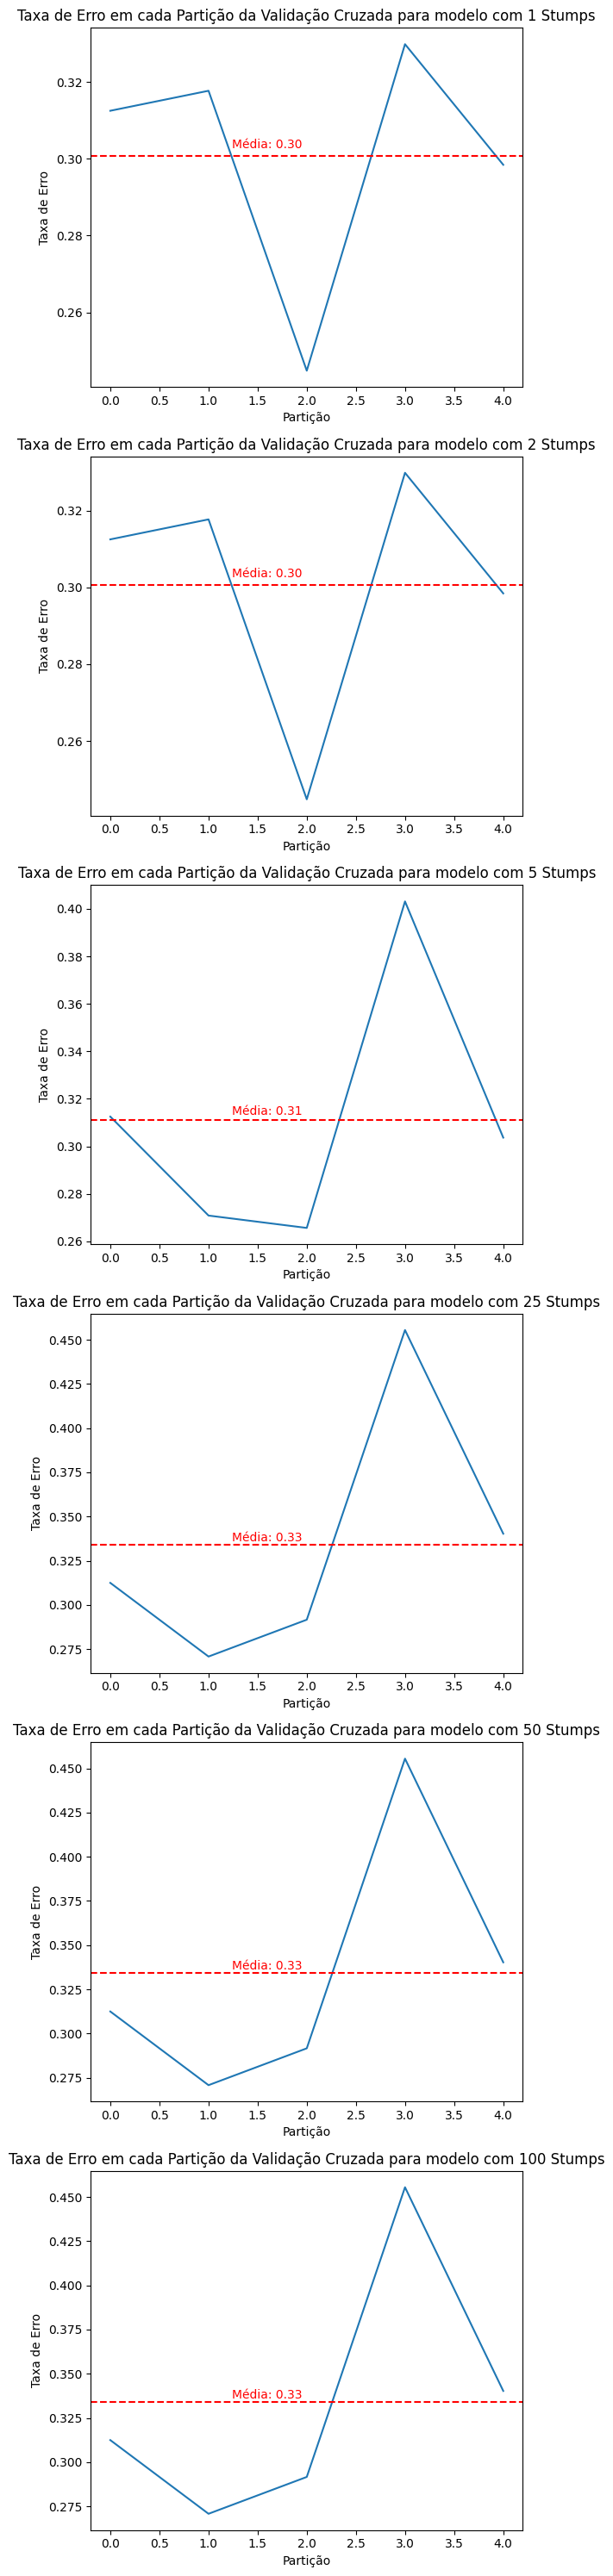

In [66]:
fig, ax = plt.subplots(nrows=6, figsize=(6, 30))
ax = ax.flatten()

for i, num_iterations in enumerate([1, 2, 5, 25, 50, 100]):
    mean_error = np.mean(errors[i])
    ax[i].plot(errors[i])
    ax[i].set_xlabel('Partição')
    ax[i].set_ylabel('Taxa de Erro')
    ax[i].set_title('Taxa de Erro em cada Partição da Validação Cruzada para modelo com {} Stumps'.format(num_iterations))
    ax[i].axhline(y=mean_error, color='r', linestyle='--')
    ax[i].annotate(f'Média: {mean_error:.2f}', xy=(0.3, mean_error + 0.002), xycoords=('axes fraction', 'data'),
                   xytext=(10, 0), textcoords='offset points', color='r')

plt.tight_layout()
plt.show()

### Avaliando o modelo com apenas 1 Stump / n_repetitions = 1

Podemos notar que com apenas um decisor(Stump) o error já se aproxima muito significando que apenas uma pergunta define muito bem se um lado vai ganhar o jogo, portanto iremos avaliar como é modelado esse stump

In [67]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

errors = []
stumps = []

for train_index, test_index in kf.split(X):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model = AdaBosting()
    model.boosting(X_train, y_train, num_interations=1)
    y_pred = model.predict(X_test)

    error = np.mean(y_test != y_pred)

    errors.append(error)

    stumps.append(model.stumps[0])
    
print(f"Taxa de erro média: {np.mean(errors)}")

Taxa de erro média: 0.3006544502617801


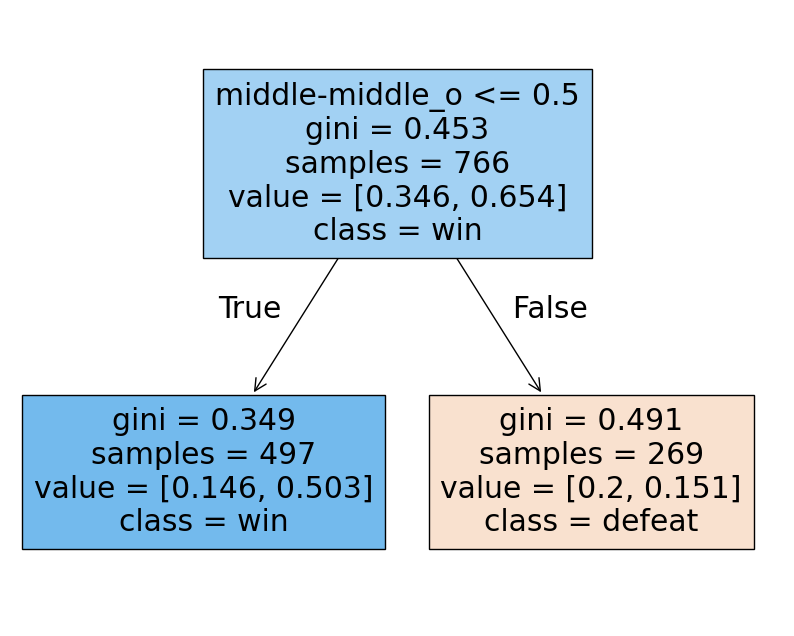

Número de nós: 3
Filhos à esquerda: [ 1 -1 -1]
Filhos à direita: [ 2 -1 -1]
Features usadas: [13 -2 -2]
Thresholds: [ 0.5 -2.  -2. ]
Nó 0:
 - Feature usada para divisão: 13
 - Threshold: 0.5
Importância das features: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


In [75]:
plt.figure(figsize=(10, 8))
plot_tree(stumps[0], filled=True, feature_names=X.columns, class_names=['defeat', 'win'])
plt.show()

# Acessar atributos importantes do stump
n_nodes = stumps[0].tree_.node_count
children_left = stumps[0].tree_.children_left
children_right = stumps[0].tree_.children_right
feature = stumps[0].tree_.feature
threshold = stumps[0].tree_.threshold

print(f"Número de nós: {n_nodes}")
print(f"Filhos à esquerda: {children_left}")
print(f"Filhos à direita: {children_right}")
print(f"Features usadas: {feature}")
print(f"Thresholds: {threshold}")

# Informações de divisão
for i in range(n_nodes):
    if children_left[i] != children_right[i]:
        print(f"Nó {i}:")
        print(f" - Feature usada para divisão: {feature[i]}")
        print(f" - Threshold: {threshold[i]}")

# Importância das features
print(f"Importância das features: {stumps[0].feature_importances_}")

Após gerar o modelo da árvore descobrimos o que parece já fazer sentido, dizer que o jogador X assinalou X na célula do meio é suficiente para acertar que ele ganhou em 70% das vezes